# Intuition behind the Longstaff-Schwartz implementation

This notebook is heavily influenced by the [Dr D. Santiago's book](https://quantgirluk.github.io/Understanding-Quantitative-Finance/AOS.html) where she discusses the Longstaff-Schwartz Algorithm to price American options. 

I find this presentation provides a great intuition to the problem at hand. 

## Geometric Brownian Motion
We will assume that the dynamics of the prices of the underlying asset follows GBM. That is to say, that the Itô process $\{X_t\}_{t\in\mathbb{N}}$ satisfies the following stochastic differential equation (SDE)

$$ \mathrm{d}X_t = rX_t \, \mathrm{d}t + \sigma X_t \, \mathrm{d}W_t   $$

with $X_0 = x_0 > 0$, where $W_t$ denotes a standard Brownian motion, and $r, \sigma$ are known parameters.

In [1]:
# Import libraries
import numpy as np
from aleatory.processes import GBM
from aleatory.utils.plotters import draw_paths

import matplotlib.pyplot as plt


## Parameters
- $r = 2\%$,
- $\sigma = 15\%$,
- $x_0 = 1.0$,
- Maturity $T=6$ (6 months),
- $N=50$ - simulating $50$ paths on the grid,
- $n=120$ - simulating $120$ time-steps (points) [20 days per month].

In [2]:
r = 0.2
sigma = 0.15
x0 = 1.0
T = 6
N = 50 # Number of paths
n = 20*6 # Number of steps
gbm = GBM(initial=x0, drift=r, volatility=sigma, T=T)
paths = gbm.simulate(n=n, N=N) # n steps, N paths

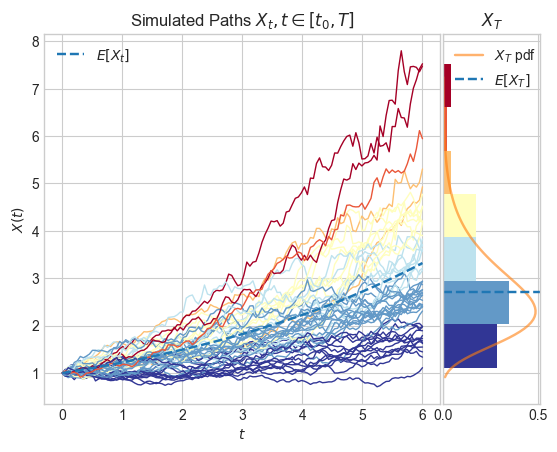

In [3]:
times = gbm.times
expectations = gbm.marginal_expectation(times)
marginalT = gbm.get_marginal(5.0)
X = np.stack(paths, axis=1)
draw_paths(times=times, paths=paths, N=N, expectations=expectations, marginalT=marginalT, marginal=True)
plt.show()

## American Option Contracts 
- $S_0 = 1.0$ Initial stock price
- We consider American $\textcolor{red}{Put}$ contract as a **writter/seller**.
- The **holder/buyer** has the right to exercise the option at any time between today (time $t_0 = 0$) and maturity $t_n = T = 6$.
- If the *holder* decides to exercise at time $t_i$, this means that he will **sell** the asset (whose market price os $S_{t_i}$ at time $t = t_i$) at price $K = 1.1 to us (*writer*).
- Why put? Assuming no dividends are being paid, **only** for the put option it is sometimes optimal to exercise earlier.
    - Why? Suppose we have a American call at time $t < T$ with the payoff $[S_t - K]^+$.
        - Alternative strategy: the option holder may short the underlying asset (which gives the payoff $S_t$), and purchsae the asset by the most favourable of 
            - exercise the American call at maturity, and
            - buying at the market price at time $T$.
        - With the alternative strategy the holder has gained amount $S_t$ at time $t$ and paid out an amount $\leq K$ at time $T. This is clearly, better than gaining the different $S_t - K$ at time $t$.
        - Hence *it is never optimal to exercise an American call option before the expiry date*.
        - American call option must have the same value as a European call option, i.e. $C^{AM} = C^{EU}$.
- For a **put option**, early exercise **can be optimal**, because:
    - You can receive  $[K - S_t]$ earlier and invest it,
    - If the option is deep in the money (i.e., $S_t \ll K$) and interest rates are positive, early exercise may dominate holding,
    - Hence: $P^{AM} \geq P^{EU}$, and strict inequality is possible
    

In [4]:
K = 1.1

## Discretisation of the domain
- If $S_{t_i} \geq K$, then the holder has **no** incentive to exercise the option (i.e. selling the asset at price $K$ makes no sense!)
- If $S_{t_i} < K$, then the option is In-The-Money (ITM) and rhe holder **may want to exercise** it. The payoff in case of exercise at time $t_i$ would be $Y(t_i) = [K- S_{t_i}]^+$

Let us visualise the times when the simulated paths have a positive payoff.

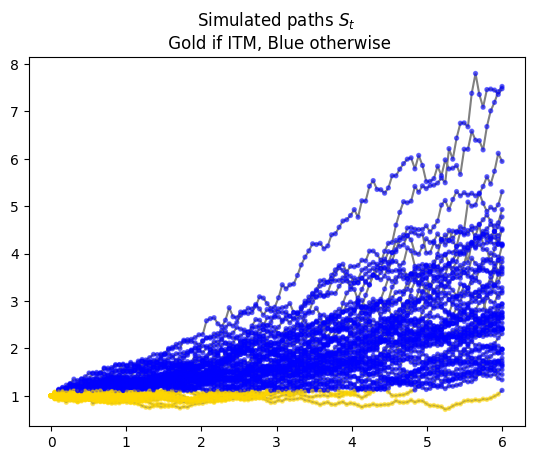

In [5]:
for path in paths:
    colors = ['gold' if (x<K) else 'blue' for x in path]
    plt.plot(times, path, color="gray")
    plt.scatter(times, path, c=colors, s=8, zorder=3, alpha=0.5)
plt.title("Simulated paths $S_t$\n Gold if ITM, Blue otherwise")
plt.show()